In [5]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.myfunctions as mf
from dask.diagnostics import ProgressBar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Processing

In [2]:
# Load WBT data
ds = xr.open_mfdataset('../data/processed/WBTdaily/WBTdailyens*.nc',combine='nested',concat_dim='ensemble',chunks={'lat':10,'lon':10})

In [4]:
# Get WBT data for a single grid cell
ds_small = ds.sel(lat=19,lon=72,method='nearest')['WBT']

In [6]:
with ProgressBar():
    ds_small.to_netcdf('../data/processed/labor_test.nc')

[########################################] | 100% Completed | 23min 46.9s


# Processed Data

In [15]:
ds = xr.open_dataset('../data/processed/labor_test.nc')

In [19]:
ds_adj = ds.where(ds>25,25)
ds_daily = 100 - 25*((ds_adj-25)**(2/3))

In [21]:
ds_yearly = ds_daily.resample(time='1Y').mean()

Text(0, 0.5, 'Labor Capacity, %')

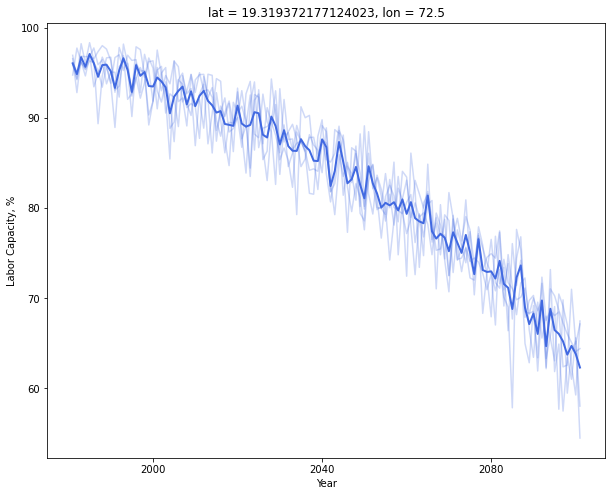

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
for ens in ds_yearly['ensemble']:
    ds_yearly.sel(ensemble=ens)['WBT'].plot(ax=ax,color='royalblue',alpha=0.25)
    
ds_avg = ds_yearly.mean(dim='ensemble')
ds_avg['WBT'].plot(ax=ax,color='royalblue',linewidth=2)
ax.set_xlabel('Year')
ax.set_ylabel('Labor Capacity, %')

# Test With Histogram Data

In [37]:
ds = xr.open_dataset('../data/processed/WBT_binned.nc')

In [71]:
region = 'India'
ds_region = ds[region]

In [97]:
# Calculate labor capacity using formula
ds_region_adj = ds_region.assign_coords({'capacity':(100 - 25*((ds_region['WBT_bin']-25)**(2/3)))})

# For WBT < 25, assign capacity = 100
ds_region_adj = ds_region_adj.assign_coords({'capacity':ds_region_adj['capacity'].where(np.isfinite(ds_region_adj['capacity']),100)})

# For WBT > 33, assign capacity = 0
ds_region_adj = ds_region_adj.assign_coords({'capacity':ds_region_adj['capacity'].where(ds_region_adj['capacity']>0,0)})

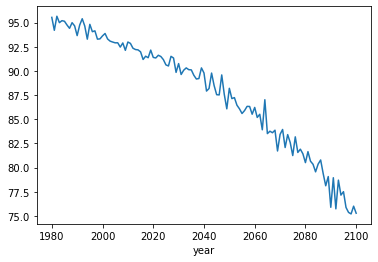

In [98]:
labor_cap = (ds_region_adj*ds_region_adj['capacity']).sum(dim='WBT_bin')
labor_cap = (labor_cap/ds_region_adj.sum(dim='WBT_bin')).mean(dim='ensemble')
labor_cap.plot()